# End to end K-means clustering of East/Southeast Asian countries

### This notebook will contain standard data analysis of these countries with an end result of the countries being segmented into clusters

#### Process:
1. Gather and wrangle data
2. Exploratory anaylsis
3. PCA
4. KMeans and plotting
5. Improve model
6. Next steps...

##### Imports:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans

## 1. Data / Data Wrangling

In [195]:
df = pd.read_csv('/Users/jschmidt345/Documents/tentative ssda data/65c9b49c-18dc-4780-b6bc-ca5b0281f6a5_Data.csv')

# string of east / pacific countries
country_list = 'Australia,Brunei,Burma,Cambodia,China,East Timor,Fiji,Indonesia,Japan,Kiribati,Laos,Malaysia,Marshall Islands,Micronesia,Mongolia,Nauru,New Zealand,North Korea,Palau,Papua New Guinea,Philippines,Samoa,Singapore,Solomon Islands,South Korea,Taiwan,Thailand,Tonga,Tuvalu,Vanuatu,Vietnam'

# turning into list
country_list = country_list.split(',')

# filtering df by those in list
df = df[df['Country Name'].isin(country_list)]

# list of unique country names found in df
unique_country_names = set(df['Country Name'])

# country name list for later
country_names = df['Country Name']


In [196]:
# Converting '..' characters to na, in order to drop missing values
for name in df.columns:
    df[name].replace('..', np.nan, inplace=True)

# Shape of dataframe prior to dropping NA
df.shape
df

,Country Name,Country Code,Time,Time Code,"Start-up procedures to register a business, male (number) [IC.REG.PROC.MA]",Current account balance (% of GDP) [BN.CAB.XOKA.GD.ZS],"Foreign direct investment, net (BoP, current US$) [BN.KLT.DINV.CD]",Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG],Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD],Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+) [FX.OWN.TOTL.ZS],...,"Inflation, consumer prices (annual %) [FP.CPI.TOTL.ZG]",Real interest rate (%) [FR.INR.RINR],Bank capital to assets ratio (%) [FB.BNK.CAPA.ZS],Net ODA received (% of GNI) [DT.ODA.ODAT.GN.ZS],"New business density (new registrations per 1,000 people ages 15-64) [IC.BUS.NDNS.ZS]",Labor tax and contributions (% of commercial profits) [IC.TAX.LABR.CP.ZS],Losses due to theft and vandalism (% of annual sales of affected firms) [IC.FRM.CRIM.ZS],Firms using banks to finance investment (% of firms) [IC.FRM.BNKS.ZS],Profit tax (% of commercial profits) [IC.TAX.PRFT.CP.ZS],"Tariff rate, applied, simple mean, all products (%) [TM.TAX.MRCH.SM.AR.ZS]"
50,Australia,AUS,2015.0,YR2015,3,-4.21387625058776,-38633221206.3589,0.901139194186968,42266.7632316925,NaN,...,1.50836672165921,6.15850255705118,5.9651012003317,NaN,15.3578444226982,21.1,NaN,NaN,26,2.5
51,Australia,AUS,2016.0,YR2016,3,-3.39513652700999,-46007279369.0228,0.117358111087469,41660.5453405894,NaN,...,1.27699094497328,5.98574231814136,6.55142987501033,NaN,15.4686598176875,21.1,NaN,NaN,26,2.3
52,Australia,AUS,2017.0,YR2017,3,-2.68999652428858,-39208833874.5164,5.14873980548556,43073.8044214876,99.5193710327148,...,1.94864740944522,1.45051082926735,6.87545,NaN,15.5656016987152,21.1,NaN,NaN,26,2.23
53,Australia,AUS,2018.0,YR2018,3,-2.04087198676786,-61473860870.3608,0.743606159010838,42732.6182267394,NaN,...,1.91140094445692,3.30362396248425,6.85508,NaN,14.4721678804391,21.1,NaN,NaN,26,2.22
54,Australia,AUS,2019.0,YR2019,3,0.511359672039268,-30863835895.4613,NaN,NaN,NaN,...,1.61076787290379,1.73965018749557,NaN,NaN,NaN,21,NaN,NaN,26.1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055,Vietnam,VNM,2015.0,YR2015,9,-1.05619348472475,-10700000000,6.90420347652889,1443.39302688117,NaN,...,0.631200905175718,7.32225813166854,8.26244709473462,1.72778812580703,1.12674488004929,24.8,3.5,29.3,14.4,6.18
1056,Vietnam,VNM,2016.0,YR2016,9,0.30446787539923,-11600000000,10.0544266591001,1572.20420918056,NaN,...,2.66824816969085,5.78509866279127,7.76780965185973,1.47751289888534,1.11793161426161,24.8,NaN,NaN,14.4,6.4
1057,Vietnam,VNM,2017.0,YR2017,9,-0.736884881932091,-13620000000,3.62542008347313,1612.70534649798,30.7957916259766,...,3.52025688811617,2.86466756426518,7.36246167448107,1.16182107460322,NaN,24.8,NaN,NaN,13.1,6.51
1058,Vietnam,VNM,2018.0,YR2018,8,2.40580086998849,-14902000000,8.82486956163217,1737.68826638364,NaN,...,3.53962805942641,3.84317485917655,7.67663496130961,0.71620303405014,NaN,24.5,NaN,NaN,13.2,6.65


In [197]:
# Getting total amount of Na values
df.isna().sum()

# Creating list of numeric cols to fill in df na's
df_numeric_cols = []
for i in df.columns[4:]:
    df_numeric_cols.append(i)

In [198]:
# fill missing values with scikit learn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

#imputer strategy
num_imputer = SimpleImputer(strategy='mean')

# define cols
num_features = df_numeric_cols

# Create an imputer (something that fills missing data)
imputer = ColumnTransformer([
    ('num_imputer', num_imputer, num_features)
])

# Transform the data
filled_df = imputer.fit_transform(df)

In [199]:
# Creating new df
filled_df = pd.DataFrame(filled_df)

filled_df.columns = df_numeric_cols

filled_df['Country Name'] = list(country_names)

## 2. Exploratory Data Analysis

In [211]:
# Descriptive Statistics
filled_df.head().describe()

,"Start-up procedures to register a business, male (number) [IC.REG.PROC.MA]",Current account balance (% of GDP) [BN.CAB.XOKA.GD.ZS],"Foreign direct investment, net (BoP, current US$) [BN.KLT.DINV.CD]",Adjusted net national income (annual % growth) [NY.ADJ.NNTY.KD.ZG],Adjusted net national income per capita (constant 2010 US$) [NY.ADJ.NNTY.PC.KD],Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+) [FX.OWN.TOTL.ZS],GINI index (World Bank estimate) [SI.POV.GINI],Ease of doing business index (1=most business-friendly regulations) [IC.BUS.EASE.XQ],Battle-related deaths (number of people) [VC.BTL.DETH],"Intentional homicides (per 100,000 people) [VC.IHR.PSRC.P5]",...,"Inflation, consumer prices (annual %) [FP.CPI.TOTL.ZG]",Real interest rate (%) [FR.INR.RINR],Bank capital to assets ratio (%) [FB.BNK.CAPA.ZS],Net ODA received (% of GNI) [DT.ODA.ODAT.GN.ZS],"New business density (new registrations per 1,000 people ages 15-64) [IC.BUS.NDNS.ZS]",Labor tax and contributions (% of commercial profits) [IC.TAX.LABR.CP.ZS],Losses due to theft and vandalism (% of annual sales of affected firms) [IC.FRM.CRIM.ZS],Firms using banks to finance investment (% of firms) [IC.FRM.BNKS.ZS],Profit tax (% of commercial profits) [IC.TAX.PRFT.CP.ZS],"Tariff rate, applied, simple mean, all products (%) [TM.TAX.MRCH.SM.AR.ZS]"
count,5.0,5.000000,5.000000e+00,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000e+00,5.000000,5.000000,5.000000
mean,3.0,-2.365704,-4.323741e+10,2.291851,36869.166938,77.959464,37.717647,67.600000,225.266667,1.527692,...,1.651235,3.727606,7.670825,10.574674,12.995318,21.080000,3.888889e+00,26.833333,26.020000,3.331065
std,0.0,1.800253,1.151926e+10,2.361855,12453.371173,12.052354,0.000000,29.963311,125.368878,0.862407,...,0.282067,2.254181,2.507032,0.000000,4.984831,0.044721,4.965068e-16,0.000000,0.044721,2.280359
min,3.0,-4.213876,-6.147386e+10,0.117358,14612.103470,72.569488,37.717647,14.000000,1.000000,0.800000,...,1.276991,1.450511,5.965101,10.574674,4.112314,21.000000,3.888889e+00,26.833333,26.000000,2.220000
25%,3.0,-3.395137,-4.600728e+10,0.743606,41660.545341,72.569488,37.717647,81.000000,281.333333,0.900000,...,1.508367,1.739650,6.551430,10.574674,14.472168,21.100000,3.888889e+00,26.833333,26.000000,2.230000
50%,3.0,-2.689997,-3.920883e+10,0.901139,42266.763232,72.569488,37.717647,81.000000,281.333333,1.000000,...,1.610768,3.303624,6.855080,10.574674,15.357844,21.100000,3.888889e+00,26.833333,26.000000,2.300000
75%,3.0,-2.040872,-3.863322e+10,4.548410,42732.618227,72.569488,37.717647,81.000000,281.333333,2.469231,...,1.911401,5.985742,6.875450,10.574674,15.468660,21.100000,3.888889e+00,26.833333,26.000000,2.500000
max,3.0,0.511360,-3.086384e+10,5.148740,43073.804421,99.519371,37.717647,81.000000,281.333333,2.469231,...,1.948647,6.158503,12.107066,10.574674,15.565602,21.100000,3.888889e+00,26.833333,26.100000,7.405323


In [271]:
# shape of new df
filled_df.shape

(115, 26)

## 3. Building K-means model

In [216]:
X = filled_df.drop('Country Name', axis=1).values

In [246]:
# finding optimal number of clusters
def find_optimal_clusters(data):
    """
    Takes in data
    Returns elbow plot
    """
    error = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i).fit(X)
        kmeans.fit(X)
        error.append(kmeans.inertia_)

    plt.plot(range(1, 11), error)
    plt.title('Elbow method')
    plt.xlabel('N Clusters')
    plt.ylabel('Error')

In [272]:
# exploring PCA
from sklearn import decomposition

# Reduced features to 2 for plotting
pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

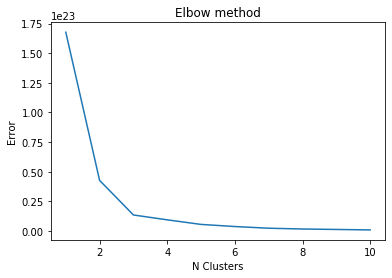

In [273]:
# from visualization we can see the optimal n of clusters is 3
find_optimal_clusters(X_pca)

In [285]:
kmeans5 = KMeans(n_clusters=3)
y_kmeans5 = kmeans5.fit_predict(X_pca)
kmeans5.cluster_centers_
y_kmeans5

array([0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2], dtype=int32)

array([[-3.81772545e+10,  2.90748049e+04],
       [-4.55513127e+10,  2.87428940e+04],
       [-3.87528672e+10,  2.99032623e+04],
       [-6.10178942e+10,  3.03906099e+04],
       [-3.04078692e+10,  1.13115017e+03],
       [-1.27907645e+09, -1.37196610e+04],
       [-1.94087471e+09, -1.36510049e+04],
       [-2.21725959e+09, -1.36020735e+04],
       [-2.63270317e+09, -1.35431626e+04],
       [-3.14822879e+09,  1.17107605e+02],
       [-6.76426831e+10, -7.25800835e+03],
       [ 4.21308428e+10, -1.10173429e+04],
       [-2.73350213e+10, -8.18975250e+03],
       [-9.18825067e+10, -5.33153615e+03],
       [-5.76559342e+10,  2.14473908e+03],
       [ 2.16652386e+08, -8.05768888e+00],
       [ 4.79143609e+07, -1.78374416e+00],
       [ 6.67210883e+07, -2.48702344e+00],
       [-1.65252885e+07,  6.06175007e-01],
       [ 9.72393698e+07, -3.62482397e+00],
       [-1.02485117e+10, -1.14159340e+04],
       [-1.56799494e+10, -1.10233553e+04],
       [-1.80460722e+10, -1.08080841e+04],
       [-1.

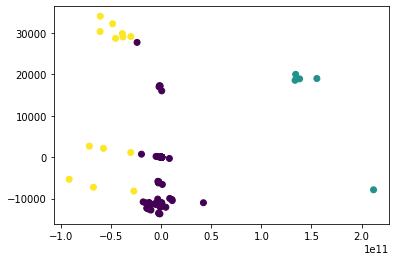

In [284]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans5)
X_pca

In [ ]:
# X_pca : still 115 "countries", but reduces to two features
# y_means : cluster value for each row in df 

In [286]:
# added cluster to df
filled_df['Cluster value'] = y_kmeans5

In [294]:
# Clusters == 0
filled_df['Country Name'][filled_df['Cluster value'] == 0]

0     Australia
1     Australia
2     Australia
3     Australia
4     Australia
10        China
12        China
13        China
14        China
81    Singapore
82    Singapore
83    Singapore
84    Singapore
Name: Country Name, dtype: object

In [292]:
# Clusters == 1
filled_df['Country Name'][filled_df['Cluster value'] == 1]

25    Japan
26    Japan
27    Japan
28    Japan
29    Japan
Name: Country Name, dtype: object

In [293]:
# Clusters == 2
filled_df['Country Name'][filled_df['Cluster value'] == 2]

5      Cambodia
6      Cambodia
7      Cambodia
8      Cambodia
9      Cambodia
         ...   
110     Vietnam
111     Vietnam
112     Vietnam
113     Vietnam
114     Vietnam
Name: Country Name, Length: 97, dtype: object

## To Do: 
- Explore more
- Functionize